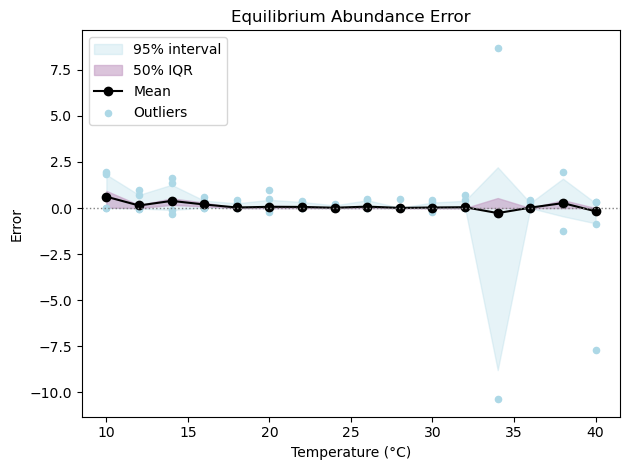

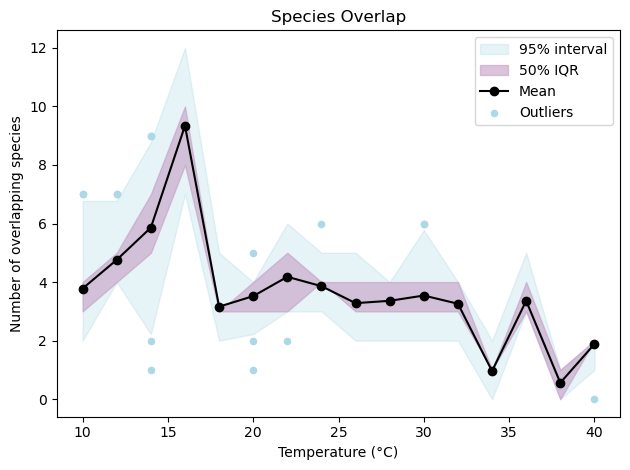

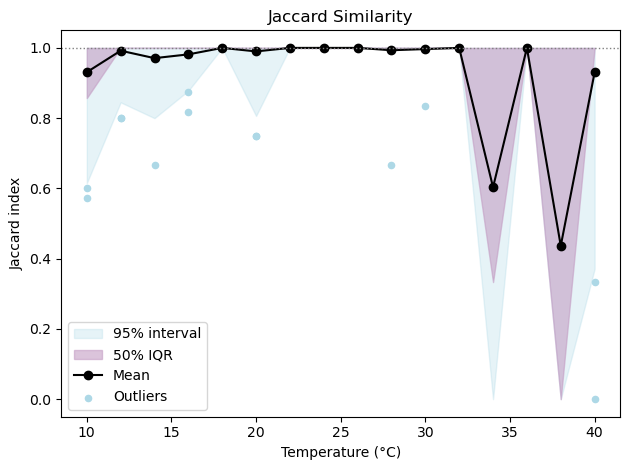

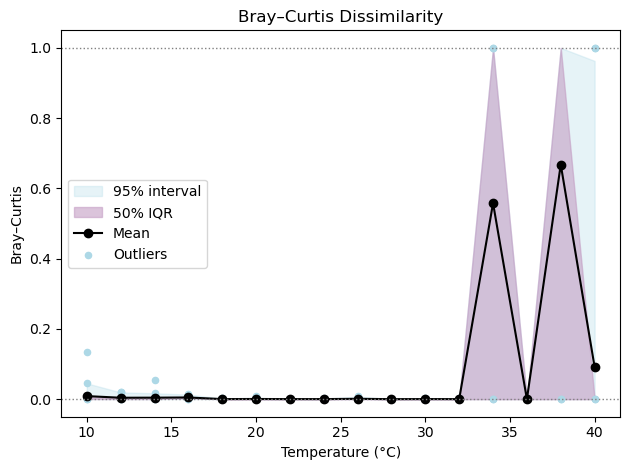

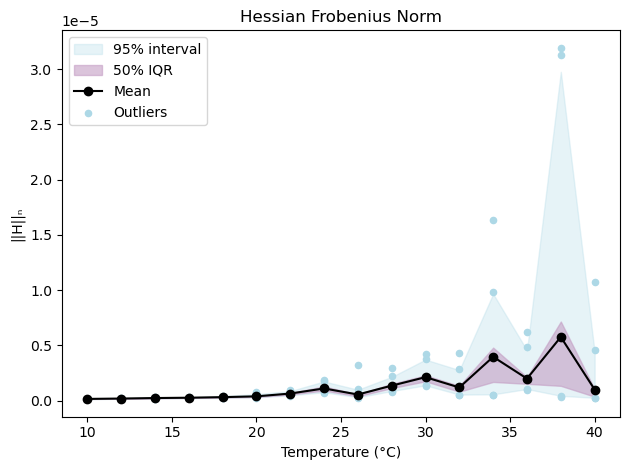

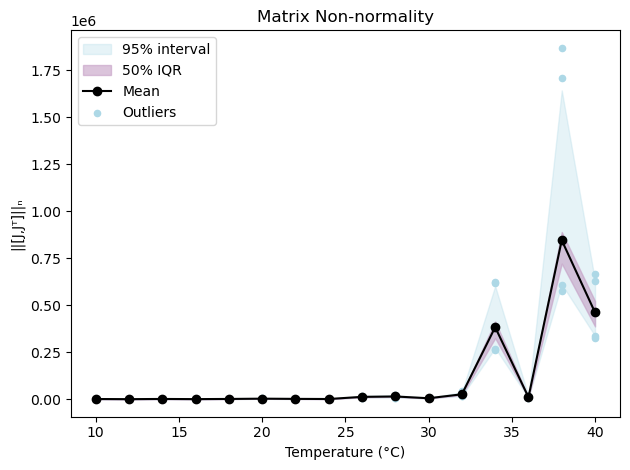

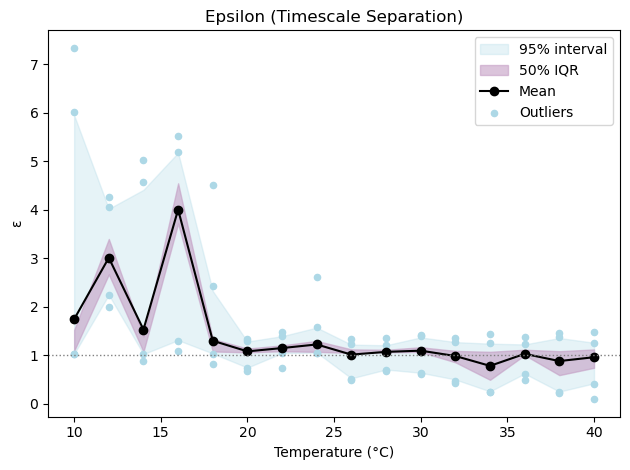

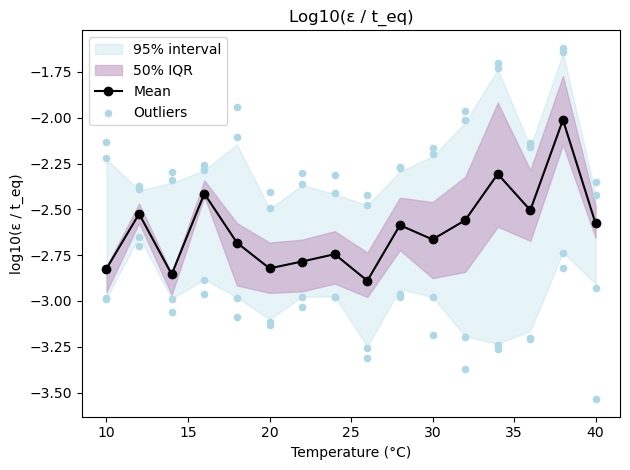

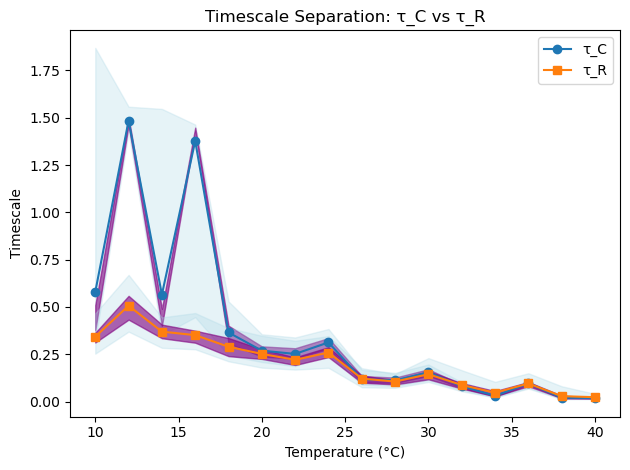

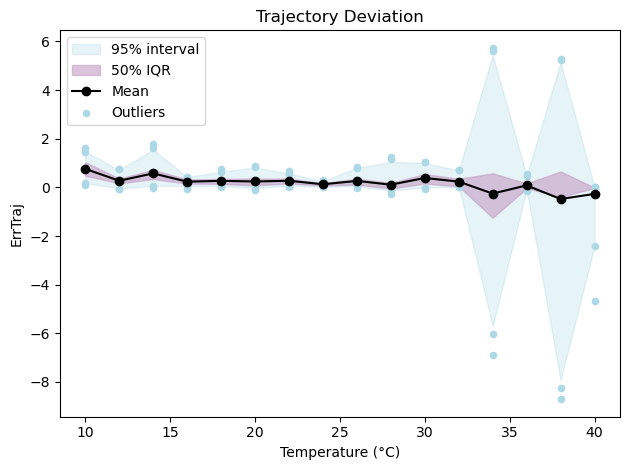

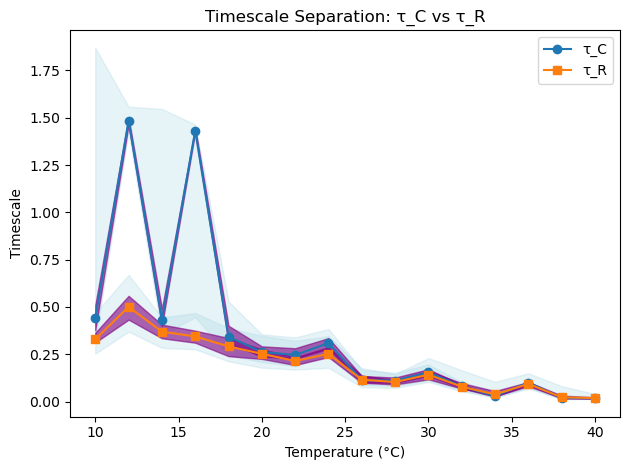

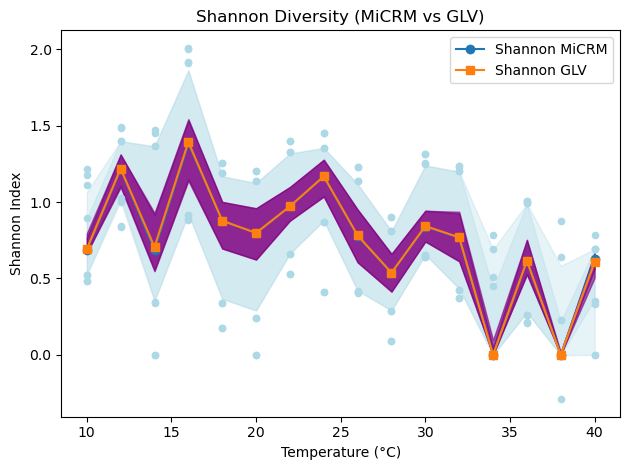

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# ─── 1) Read & clean ─────────────────────────────────────────────────────────
metrics_fp = "output/metrics_final.csv"


df = pd.read_csv(metrics_fp)
# parse any "(real+0j)" strings → real floats
for col in ['stab_mi','stab_glv','react_mi','react_glv']:
    if col in df:
        df[col] = (df[col]
            .apply(lambda x: ast.literal_eval(x).real if isinstance(x,str) and '+' in x else x)
            .astype(float)
        )
df['T_C'] = df['T_K'] - 273.15




# ─── 2) Stats helper ─────────────────────────────────────────────────────────
def get_stats(series):
    mean = series.mean()
    p25, p75 = series.quantile([0.25,0.75])
    p025, p975 = series.quantile([0.025,0.975])
    return mean, p25, p75, p025, p975

# ─── 3) Universal plot function ──────────────────────────────────────────────
def plot_metric(df, col, title, ylabel, hlines=None, hline=None):
    temps = sorted(df['T_C'].unique())
    means, p25s, p75s, low95s, hi95s = [], [], [], [], []
    out_x, out_y = [], []
    for T in temps:
        vals = df[df['T_C']==T][col]
        m, p25, p75, l95, u95 = get_stats(vals)
        means.append(m); p25s.append(p25); p75s.append(p75)
        low95s.append(l95); hi95s.append(u95)
        mask = (vals < l95) | (vals > u95)
        out_x.extend([T]*mask.sum())
        out_y.extend(vals[mask])

    # color scheme
    c50, c95 = '#c49ec4', 'lightblue'

    fig, ax = plt.subplots()
    ax.fill_between(temps, low95s, hi95s, color=c95, alpha=0.3, label='95% interval')
    ax.fill_between(temps, p25s, p75s, color=c50, alpha=0.6, label='50% IQR')
    ax.plot(temps, means, '-o', color='k', label='Mean')
    if out_x:
        ax.scatter(out_x, out_y, color=c95, s=20, label='Outliers')

    # reference lines
    if hline is not None:
        ax.axhline(hline, linestyle=':', linewidth=1, color='gray')
    if hlines:
        for y in hlines:
            ax.axhline(y, linestyle=':', linewidth=1, color='gray')

    ax.set_title(title)
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.tight_layout()

# ─── 4) Individual plots ─────────────────────────────────────────────────────
plot_metric(df, 'ErrEqAb',
            title='Equilibrium Abundance Error',
            ylabel='Error',
            hline=0)

plot_metric(df, 'overlap',
            title='Species Overlap',
            ylabel='Number of overlapping species')

plot_metric(df, 'jaccard',
            title='Jaccard Similarity',
            ylabel='Jaccard index',
            hline=1.0)

plot_metric(df, 'bray_curtis',
            title='Bray–Curtis Dissimilarity',
            ylabel='Bray–Curtis',
            hlines=[0,1])

plot_metric(df, 'hessian_norm',
            title='Hessian Frobenius Norm',
            ylabel='||H||ₙ')

plot_metric(df, 'non_normality',
            title='Matrix Non-normality',
            ylabel='||[J,Jᵀ]||ₙ')

plot_metric(df, 'epsilon',
            title='Epsilon (Timescale Separation)',
            ylabel='ε',
            hline=1.0)

plot_metric(df, 'log10_eps_t_eq',
            title='Log10(ε / t_eq)',
            ylabel='log10(ε / t_eq)')

# tau_C vs tau_R
temps = sorted(df['T_C'].unique())
tauC_mean, tauC_p25, tauC_p75, tauC_l95, tauC_u95 = zip(*[get_stats(df[df['T_C']==T]['tau_C']) for T in temps])
tauR_mean, tauR_p25, tauR_p75, tauR_l95, tauR_u95 = zip(*[get_stats(df[df['T_C']==T]['tau_R']) for T in temps])

fig, ax = plt.subplots()
ax.fill_between(temps, tauC_l95, tauC_u95, color='lightblue', alpha=0.3)
ax.fill_between(temps, tauC_p25, tauC_p75, color='purple', alpha=0.6)
ax.plot(temps, tauC_mean, '-o', label='τ_C')

ax.fill_between(temps, tauR_l95, tauR_u95, color='lightblue', alpha=0.3)
ax.fill_between(temps, tauR_p25, tauR_p75, color='purple', alpha=0.6)
ax.plot(temps, tauR_mean, '-s', label='τ_R')

ax.set_title('Timescale Separation: τ_C vs τ_R')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Timescale')
ax.legend()
fig.tight_layout()

# trajectory deviation
plot_metric(df, 'ErrTraj',
            title='Trajectory Deviation',
            ylabel='ErrTraj')

# ─── 5) Show all ─────────────────────────────────────────────────────────────
plt.show()

def plot_tau_C_vs_tau_R(df):
    temps = sorted(df['T_C'].unique())
    
    # Compute median, IQR (25–75%), and 95% bounds for a column
    def stats(col):
        q = df.groupby('T_C')[col].quantile([0.5, 0.25, 0.75, 0.025, 0.975]).unstack()
        return q[0.5].values, q[0.25].values, q[0.75].values, q[0.025].values, q[0.975].values

    mC, p25C, p75C, l95C, u95C = stats('tau_C')
    mR, p25R, p75R, l95R, u95R = stats('tau_R')

    fig, ax = plt.subplots()
    # 95% confidence bands
    ax.fill_between(temps, l95C, u95C, color='lightblue', alpha=0.3)
    ax.fill_between(temps, l95R, u95R, color='lightblue', alpha=0.3)
    # 50% IQR bands
    ax.fill_between(temps, p25C, p75C, color='purple', alpha=0.6)
    ax.fill_between(temps, p25R, p75R, color='purple', alpha=0.6)
    # Median lines + markers
    ax.plot(temps, mC, '-o', label='τ_C')
    ax.plot(temps, mR, '-s', label='τ_R')

    ax.set_title('Timescale Separation: τ_C vs τ_R')
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Timescale')
    ax.legend()
    fig.tight_layout()
    plt.show()

# Then simply call:
plot_tau_C_vs_tau_R(df)


def plot_shannon_diversity(df):
    """
    Overlay Shannon diversity for MiCRM vs GLV:
    - Mean ±50% IQR (purple)
    - Mean ±95% interval (light blue)
    - Mean line + markers
    - Outliers in light blue
    """
    temps = sorted(df['T_C'].unique())
    def stats(col):
        q = df.groupby('T_C')[col].quantile([0.5, 0.25, 0.75, 0.025, 0.975]).unstack()
        return q[0.5].values, q[0.25].values, q[0.75].values, q[0.025].values, q[0.975].values

    # Compute stats
    m_mi, p25_mi, p75_mi, l95_mi, u95_mi = stats('shannon_mi')
    m_lv, p25_lv, p75_lv, l95_lv, u95_lv = stats('shannon_lv')

    fig, ax = plt.subplots()
    # 95% bands
    ax.fill_between(temps, l95_mi, u95_mi, color='lightblue', alpha=0.3)
    ax.fill_between(temps, l95_lv, u95_lv, color='lightblue', alpha=0.3)
    # 50% IQR bands
    ax.fill_between(temps, p25_mi, p75_mi, color='purple', alpha=0.6)
    ax.fill_between(temps, p25_lv, p75_lv, color='purple', alpha=0.6)
    # Mean lines + markers
    ax.plot(temps, m_mi, '-o', label='Shannon MiCRM')
    ax.plot(temps, m_lv, '-s', label='Shannon GLV')
    # Outliers
    for col, l95, u95 in [('shannon_mi', l95_mi, u95_mi), ('shannon_lv', l95_lv, u95_lv)]:
        vals = df[col]
        xs, ys = [], []
        for T in temps:
            v = df[df['T_C']==T][col]
            mask = (v < df[df['T_C']==T][col].quantile(0.025)) | (v > df[df['T_C']==T][col].quantile(0.975))
            xs.extend([T]*mask.sum()); ys.extend(v[mask])
        if xs:
            ax.scatter(xs, ys, color='lightblue', s=20)

    ax.set_title('Shannon Diversity (MiCRM vs GLV)')
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Shannon Index')
    ax.legend()
    fig.tight_layout()
    plt.show()

# Call it:
plot_shannon_diversity(df)


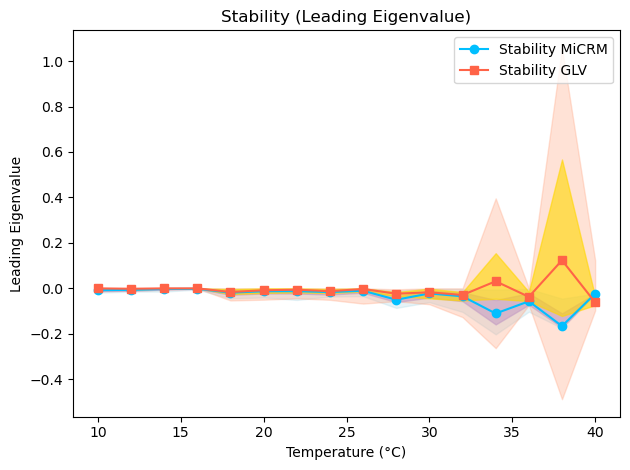

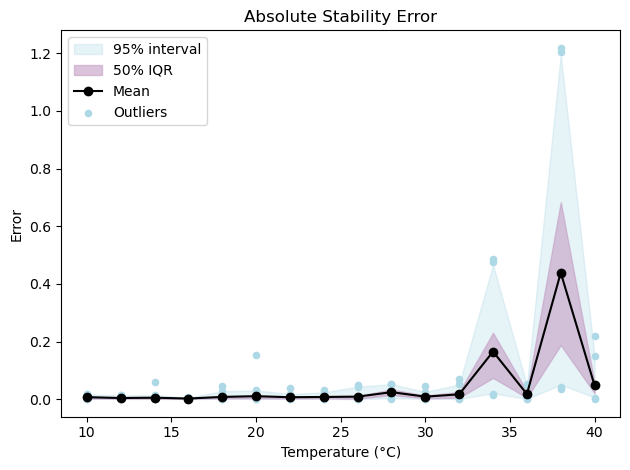

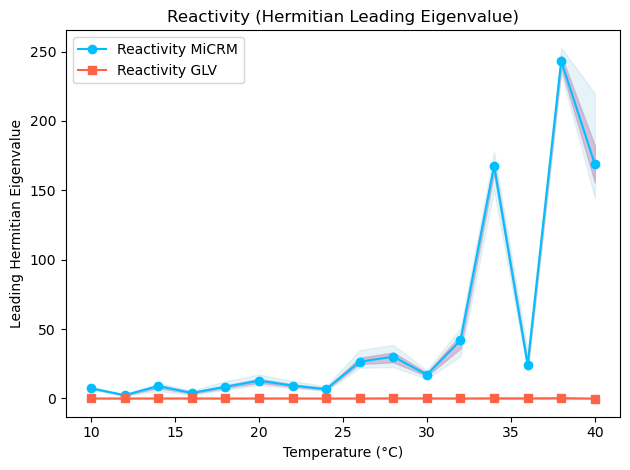

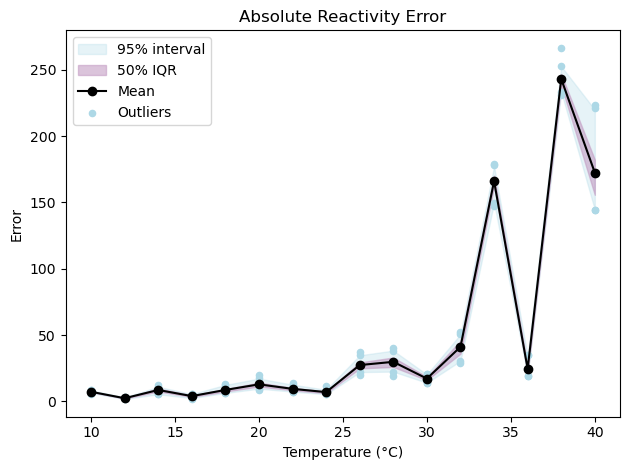

In [4]:

def plot_overlay(df, col1, col2, lab1, lab2, title, ylabel, hlines=None, hline=None):
    temps = sorted(df['T_C'].unique())
    def stats(col):
        q = df.groupby('T_C')[col].quantile([0.5,0.25,0.75,0.025,0.975]).unstack()
        return (q[0.5].values, q[0.25].values, q[0.75].values,
                q[0.025].values, q[0.975].values)

    m1, p25_1, p75_1, lo95_1, hi95_1 = stats(col1)
    m2, p25_2, p75_2, lo95_2, hi95_2 = stats(col2)

    fig, ax = plt.subplots()
    ax.fill_between(temps, lo95_1, hi95_1, color='lightblue', alpha=0.3)
    ax.fill_between(temps, lo95_2, hi95_2, color='#ffa07a', alpha=0.3)
    ax.fill_between(temps, p25_1, p75_1, color='#c49ec4', alpha=0.6)
    ax.fill_between(temps, p25_2, p75_2, color='#ffd700', alpha=0.6)
    ax.plot(temps, m1, '-o', label=lab1, color="#00bfff")
    ax.plot(temps, m2, '-s', label=lab2, color="#ff6347")

    if hline is not None:
        ax.axhline(hline, linestyle=':', color='gray')
    if hlines:
        for y in hlines:
            ax.axhline(y, linestyle=':', color='gray')

    ax.set_title(title)
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.tight_layout()


plot_overlay(df, 'stab_mi', 'stab_glv',
             'Stability MiCRM', 'Stability GLV',
             title='Stability (Leading Eigenvalue)',
             ylabel='Leading Eigenvalue')

plot_metric(df, 'abs_stab_err',
            title='Absolute Stability Error',
            ylabel='Error')

# Reactivity
plot_overlay(df, 'react_mi', 'react_glv',
             'Reactivity MiCRM', 'Reactivity GLV',
             title='Reactivity (Hermitian Leading Eigenvalue)',
             ylabel='Leading Hermitian Eigenvalue')

plot_metric(df, 'abs_react_err',
            title='Absolute Reactivity Error',
            ylabel='Error')


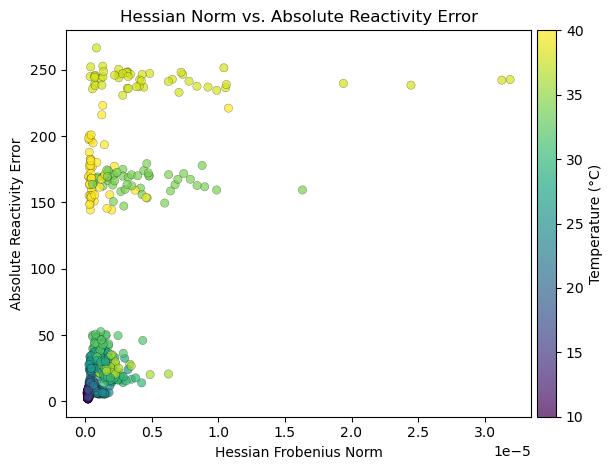

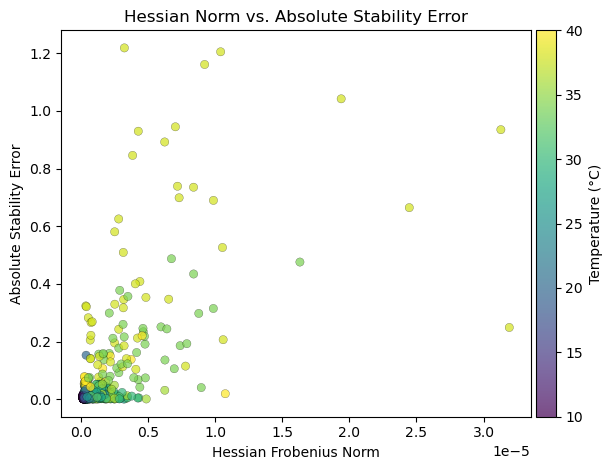

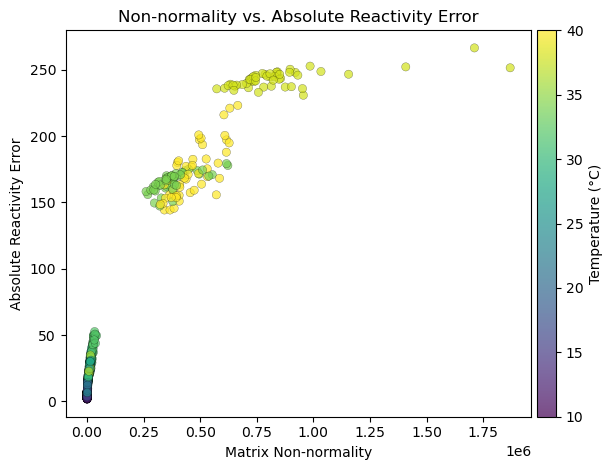

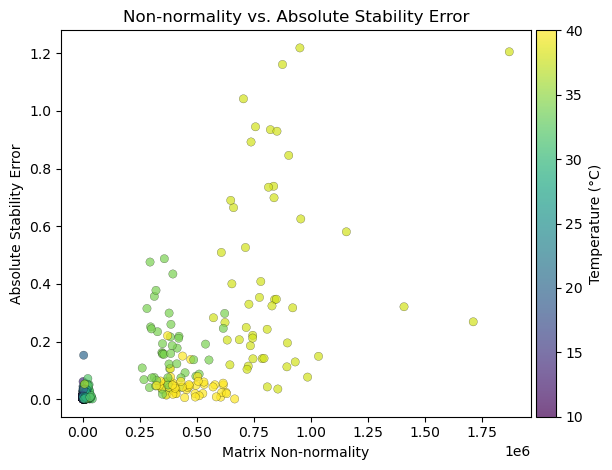

In [5]:
# ─── 6) Relationship plots ───────────────────────────────────────────────────
import matplotlib.pyplot as plt

# Define each pair: (xcol, ycol, x label, y label, title)
pairs = [
    ('hessian_norm',   'abs_react_err',
     'Hessian Frobenius Norm', 'Absolute Reactivity Error',
     'Hessian Norm vs. Absolute Reactivity Error'),
    ('hessian_norm',   'abs_stab_err',
     'Hessian Frobenius Norm', 'Absolute Stability Error',
     'Hessian Norm vs. Absolute Stability Error'),
    ('non_normality',  'abs_react_err',
     'Matrix Non-normality', 'Absolute Reactivity Error',
     'Non-normality vs. Absolute Reactivity Error'),
    ('non_normality',  'abs_stab_err',
     'Matrix Non-normality', 'Absolute Stability Error',
     'Non-normality vs. Absolute Stability Error'),
]

for xcol, ycol, xl, yl, title in pairs:
    fig, ax = plt.subplots()
    sc = ax.scatter(
        df[xcol], df[ycol],
        c=df['T_C'], cmap='viridis',
        alpha=0.7, edgecolor='k', linewidth=0.2
    )
    cbar = plt.colorbar(sc, ax=ax, pad=0.01)
    cbar.set_label('Temperature (°C)')
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.set_title(title)
    fig.tight_layout()

plt.show()


In [6]:
import pandas as pd
import numpy as np

# 1. load your original CSV
df = pd.read_csv("output/metrics_final.csv")

# 2. build a mapping old‐Tₖ → new bin label (we’ll use the lower °C bound in Kelvin)
#    define the bin edges in °C, then convert to Kelvin
bin_edges_C = np.arange(10, 40 + 4, 4)    # [10,14,18,…,38,42]
bin_edges_K = bin_edges_C + 273.15        # [283.15,287.15,…,311.15,315.15]

# 3. assign each Tₖ to its 4 °C bin
#    we’ll label each group by its lower‐edge Kelvin value
df["T_bin_K"] = pd.cut(
    df["T_K"],
    bins=bin_edges_K,
    right=False,                         # include left edge, exclude right
    labels=bin_edges_K[:-1]             # labels: 283.15, 287.15, …, 311.15
).astype(float)

# 4. check counts (should be 100 replicates × 2 temps = 200 rows per bin)
print(df["T_bin_K"].value_counts().sort_index())

# 5. save your new “coarse‐by‐4°C” CSV
df.to_csv("output/metrics_final_coarse.csv", index=False)


283.15    100
287.15    100
291.15    100
295.15    100
299.15    100
303.15    100
307.15    100
311.15    100
Name: T_bin_K, dtype: int64


In [7]:
df2 = pd.read_csv("output/metrics_final_coarse.csv")
print(df2.head())
print(df2["T_bin_K"].value_counts().sort_index())

   replicate     T_K   T_C       ErrEqAb  overlap  jaccard  shannon_mi  \
0          1  283.15  10.0  1.662477e-02        3      1.0    0.624486   
1          1  285.15  12.0  3.880238e-01        5      1.0    0.998312   
2          1  287.15  14.0  3.959931e-01        7      1.0    0.848823   
3          1  289.15  16.0  1.264008e-01       10      1.0    1.330927   
4          1  291.15  18.0 -1.883254e-08        3      1.0    0.823374   

   shannon_lv   bray_curtis   ErrTraj  ...  react_mi  react_glv abs_react_err  \
0    0.630321  2.812301e-03  0.356656  ...  7.676786   0.006830      7.669956   
1    1.028794  1.401687e-02  0.463719  ...  3.121736   0.040205      3.081531   
2    0.852184  1.612533e-03  0.334865  ...  8.216286   0.036489      8.179797   
3    1.353685  6.599631e-03  0.193196  ...  3.472050   0.044933      3.427117   
4    0.823374  6.585219e-09  0.130940  ...  9.264578  -0.007119      9.271696   

      tau_C     tau_R   epsilon  log10_eps_t_eq  hessian_norm  non_n